In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Load the training, validation, and test data
train_df = pd.read_csv('Training/train_2013_2020.csv', parse_dates=["Date"])
valid_df = pd.read_csv('Training/valid_2021_2022.csv', parse_dates=["Date"])
test_df = pd.read_csv('Training/test_2023_2025.csv', parse_dates=["Date"])

print("\nDataframe loaded!")


Dataframe loaded!


In [2]:
# Sort by Date to ensure correct ordering
train_df.sort_values(by=["Date", "Ticker"], inplace=True)
valid_df.sort_values(by=["Date", "Ticker"], inplace=True)
test_df.sort_values(by=["Date", "Ticker"], inplace=True)

# Encode Ticker
label_encoder = LabelEncoder()
train_df['Ticker'] = label_encoder.fit_transform(train_df['Ticker'])
valid_df['Ticker'] = label_encoder.transform(valid_df['Ticker'])
test_df['Ticker'] = label_encoder.transform(test_df['Ticker'])

# Separate features and targets
train_features = train_df.drop(columns=['Date', '5_day_return'])
valid_features = valid_df.drop(columns=['Date', '5_day_return'])
test_features = test_df.drop(columns=['Date', '5_day_return'])
y_train = train_df['5_day_return'].values
y_val = valid_df['5_day_return'].values
y_test = test_df['5_day_return'].values

# Normalize features
scaler = MinMaxScaler()
train_scaled_features = scaler.fit_transform(train_features)
valid_scaled_features = scaler.transform(valid_features)
test_scaled_features = scaler.transform(test_features)

# Sequence generator
def create_sequences(features, targets, window_size=60):
    X, y = [], []
    for i in range(window_size, len(features)):
        X.append(features[i - window_size:i])
        y.append(targets[i])
    return np.array(X), np.array(y)

# Create LSTM-ready sequences
X_train, y_train = create_sequences(train_scaled_features, y_train)
X_val, y_val = create_sequences(valid_scaled_features, y_val)
X_test, y_test = create_sequences(test_scaled_features, y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

print(f"✅ Training shape: {X_train_tensor.shape}")
print(f"✅ Validation shape: {X_val_tensor.shape}")
print(f"✅ Test shape: {X_test_tensor.shape}")


✅ Training shape: torch.Size([18100, 60, 17])
✅ Validation shape: torch.Size([4970, 60, 17])
✅ Test shape: torch.Size([5550, 60, 17])


In [3]:
import torch
import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self, input_size):
        super(StockLSTM, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=64, batch_first=True, dropout=0.0, num_layers=1)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True, dropout=0.0, num_layers=1)
        
        self.fc1 = nn.Linear(32, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]  # Get the output of the last time step
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [4]:
input_size = X_train_tensor.shape[2]  # Number of features per time step
model = StockLSTM(input_size)
print(model)


StockLSTM(
  (lstm1): LSTM(17, 64, batch_first=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.amp import GradScaler, autocast

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Create Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize GradScaler for mixed precision
scaler = GradScaler()

# Training loop
num_epochs = 200
train_losses = []
val_losses = []

from torch.amp import GradScaler, autocast

# Initialize GradScaler for mixed precision
scaler = GradScaler()

# In the training loop, use autocast for mixed precision
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        # Use autocast for mixed precision with device_type='cuda'
        with autocast(device_type='cuda'):  # This enables automatic mixed precision (AMP)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

        # Scales the loss and calls backward()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.detach().item()  # detach the tensor before using item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Use autocast during evaluation as well with device_type='cuda'
            with autocast(device_type='cuda'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.detach().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Epoch [1/200], Train Loss: 21.8428, Val Loss: 31.1500
Epoch [10/200], Train Loss: 21.7974, Val Loss: 31.1276
Epoch [20/200], Train Loss: 21.5211, Val Loss: 30.8396
Epoch [30/200], Train Loss: 21.3818, Val Loss: 30.7225
Epoch [40/200], Train Loss: 21.2366, Val Loss: 30.4834
Epoch [50/200], Train Loss: 19.6957, Val Loss: 30.5702
Epoch [60/200], Train Loss: 17.7637, Val Loss: 42.0936
Epoch [70/200], Train Loss: 15.8834, Val Loss: 49.4402
Epoch [80/200], Train Loss: 14.7198, Val Loss: 58.7575
Epoch [90/200], Train Loss: 12.8223, Val Loss: 69.1565
Epoch [100/200], Train Loss: 11.3010, Val Loss: 75.8288
Epoch [110/200], Train Loss: 9.7784, Val Loss: 83.3545
Epoch [120/200], Train Loss: 8.7654, Val Loss: 70.0489
Epoch [130/200], Train Loss: 7.7831, Val Loss: 85.5873
Epoch [140/200], Train Loss: 6.7255, Val Loss: 68.6069
Epoch [150/200], Train Loss: 5.8680, Val Loss: 85.8312
Epoch [160/200], Train Loss: 5.3890, Val Loss: 85.4957
Epoch [170/200], Train Loss: 4.8712, Val Loss: 99.4987
Epoch [180

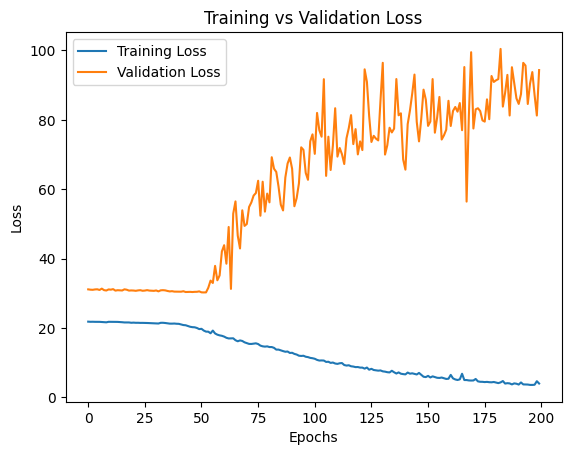

In [6]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set the model to evaluation mode
model.eval()

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create test DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Store predictions and true values
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

# Flatten the list of predictions and true values
y_pred = np.array(y_pred).flatten()
y_true = np.array(y_true).flatten()

# Calculate MAE, MSE, and R-squared
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")


Mean Absolute Error (MAE): 8.138192176818848
Mean Squared Error (MSE): 110.57970428466797
R-squared: -3.040640354156494
